# Кредитный скоринг

Вопрос в том, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Результаты исследовнаия будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Получение данных

Входные данные от банка — статистика о платёжеспособности клиентов.
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

In [1]:
# Импортируем библиотеки
import pandas as pd
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Получаем данные из файла
try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('/datasets/data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

- Названия столбцов соответсвтуют универсальному виду.

- Непонятна природа дробных чисел в столбцах days_employed и total_income. 

- В столбце days_employed встречаются отрицательные числа, а также аутлайеры.

### Заполнение пропусков в датафрейме

In [4]:
# Ищем пропуски среди чисел
print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


<a id='match'></a>

In [5]:
print(data.loc[data['days_employed'].isna()].index.to_list()\
      == data.loc[data['total_income'].isna()].index.to_list()) 

True


Из чего можно сделать вывод о том, что пропуски в двух столбцах совпадают по строкам

In [6]:
gaps = data.loc[data['total_income'].isna()]

На сумму доходов сильнее всего влияет тип занятости, поэтому пропуски среди суммы доходов заменяются медианным значением по каждому типу из столбца `income_type`.

In [7]:
# Удостоверимся, что среди типов нет дубликатов
print(data['income_type'].unique())

['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']


In [8]:
print(data['income_type'].value_counts())

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64


In [9]:
print(data['total_income'].duplicated().sum())
print(data['total_income'].value_counts())

2173
169846.427535    1
257737.077768    1
200508.675866    1
106196.235958    1
248730.171354    1
                ..
175057.266090    1
101516.604975    1
239154.168013    1
165009.733021    1
189255.286637    1
Name: total_income, Length: 19351, dtype: int64


In [10]:
# Заполняем пропуски в доходах медианами
data['total_income'] = data.groupby('income_type')['total_income']\
.transform(lambda x: x.fillna(x.median())) #  По умолчанию пропускает NaN при подсчёте
print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64


In [11]:
print(data['total_income'].duplicated().sum())
print(data['total_income'].value_counts())

2172
142594.396847    1105
172357.950966     509
118514.486412     414
150447.935283     147
499163.144947       2
                 ... 
101516.604975       1
239154.168013       1
165009.733021       1
94270.049769        1
189255.286637       1
Name: total_income, Length: 19353, dtype: int64


Получается, дубликаты действительно заменились медианами по типам доходов.

Изучим теперь пропуски в днях трудового стажа.

In [12]:
print(data['days_employed'].duplicated().sum())
print(data['days_employed'].value_counts())
print(data['days_employed'].value_counts().sort_index())

2173
-327.685916     1
-1580.622577    1
-4122.460569    1
-2828.237691    1
-2636.090517    1
               ..
-7120.517564    1
-2146.884040    1
-881.454684     1
-794.666350     1
-3382.113891    1
Name: days_employed, Length: 19351, dtype: int64
-18388.949901     1
-17615.563266     1
-16593.472817     1
-16264.699501     1
-16119.687737     1
                 ..
 401663.850046    1
 401674.466633    1
 401675.093434    1
 401715.811749    1
 401755.400475    1
Name: days_employed, Length: 19351, dtype: int64


К артефактам среди чисел в столбце days_employed можно отнести:
- отрицательные числа
- аномально высокие числа (1100 лет – это круто даже для пенсионеров)

Всё ещё непонятно, почему стаж дробный. Не покидает чувство причастности метода random.random() к процессу получения данных в столбцах days_employed и total_income.

Поменяем знак у отрицательных чисел:

In [13]:
# Исправляем артефакты в столбце days_employed: меняем знаки
data['days_employed'] = abs(data['days_employed'])
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [14]:
# Оцениваем трудовой стаж по типам занятости медианой:
print(data.groupby('income_type')['days_employed'].median())

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64


Числа, внушающие благоговение.

In [15]:
print(data['children'].unique())

[ 1  0  3  2 -1  4 20  5]


In [16]:
data.loc[data['children'] == -1]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,Среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,на покупку своего автомобиля
1363,-1,1195.264956,55,СРЕДНЕЕ,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование
1929,-1,1461.303336,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья
2073,-1,2539.761232,42,среднее,1,в разводе,3,F,компаньон,0,162638.609373,покупка жилья
3814,-1,3045.290443,26,Среднее,1,гражданский брак,1,F,госслужащий,0,131892.785435,на проведение свадьбы
4201,-1,901.101738,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375.766751,операции со своей недвижимостью


In [17]:
data.loc[data['children'] == 20]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля
...,...,...,...,...,...,...,...,...,...,...,...,...
21008,20,1240.257910,40,среднее,1,женат / замужем,0,F,сотрудник,1,133524.010303,свой автомобиль
21325,20,601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,NaN,53,среднее,1,женат / замужем,0,M,компаньон,0,172357.950966,покупка жилой недвижимости
21404,20,494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


In [18]:
data = data.loc[(data['children'] != -1) & (data['children'] != 20)]
print(data['children'].unique())

[1 0 3 2 4 5]


In [19]:
# Заполняем пропуски в трудовом стаже медианами
data['days_employed'] = data.groupby('income_type')['days_employed']\
.transform(lambda x: x.fillna(x.median())) # Пропускает NaN при подсчёте по умолчанию
data.isna().sum()

/tmp/ipykernel_9007/3879261291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_employed'] = data.groupby('income_type')['days_employed']\


children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [20]:
data['total_income'] = data['total_income'].astype(int)
data.head(10)

/tmp/ipykernel_9007/1229819081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_income'] = data['total_income'].astype(int)


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


In [21]:
print(data['education'].unique())

['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']


In [22]:
data['education'] = data['education'].replace(['Среднее', 'СРЕДНЕЕ'], 'среднее')
data['education'] = data['education'].replace(['ВЫСШЕЕ', 'Высшее'], 'высшее')
data['education'] = data['education'].replace(['Неоконченное высшее', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ'],\
                                              'неоконченное высшее')
data['education'] = data['education'].replace(['НАЧАЛЬНОЕ', 'Начальное'], 'начальное')
data['education'] = data['education'].replace(['Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ'], 'ученая степень')
data['education'].unique()

# data['education'] = data['education'].str.lower() 

/tmp/ipykernel_9007/3638091496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'] = data['education'].replace(['Среднее', 'СРЕДНЕЕ'], 'среднее')
/tmp/ipykernel_9007/3638091496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'] = data['education'].replace(['ВЫСШЕЕ', 'Высшее'], 'высшее')
/tmp/ipykernel_9007/3638091496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  int64  
 11  purpose           21402 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


### Удаление дубликатов

In [24]:
print(data.duplicated().sum())

71


In [25]:
data = data.drop_duplicates().reset_index(drop=True)
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


### Категоризация доходов

In [26]:
def total_income_category(income):
    if 0 <= income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001 <= income <= 200000:
        return 'C'
    elif 200001 <= income <= 1000000:
        return 'B'
    elif 1000001 <= income:
        return 'A'
    else:
        raise ValueError("income is not a positive integer")

In [27]:
data['total_income_category'] = data['total_income'].apply(total_income_category)
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21326,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,B
21327,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,C
21328,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,C
21329,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,B


In [28]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [29]:
def categorize_purpose(purpose):
    if 'автомобил' in purpose:
        return 'операции с автомобилем'
    elif 'жиль' in purpose or 'недвижимо' in purpose:
        return 'операции с недвижимостью'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'
    elif 'образовани' in purpose:
        return 'получение образования'
    else:
        print(purpose)
        raise ValueError("unpredictable purpose")

In [30]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


## Поиск корреляции между данными и задолженностями по кредитам

Для начала надо понять, факт ли задолженности в столбце debt или число этих задолженностей

In [31]:
print(data['debt'].unique())

[0 1]


Видимо, факт. С ним будем искать корреляцию

### Корреляция можду числом детей и фактом задолженности

In [32]:
data_by_children = data.groupby('children').agg({'debt': ['count', 'sum']})
# Мультииндекс здесь неудобен
data_by_children.columns = data_by_children.columns.droplevel()
data_by_children

,count,sum
children,,
0,14091,1063
1,4808,444
2,2052,194
3,330,27
4,41,4
5,9,0


Найдём долю людей с задолженностью

In [33]:
data_by_children['ratio'] = data_by_children['sum'] / data_by_children['count']
data_by_children['%'] = round(data_by_children['ratio'] * 100, 1)
print(data_by_children)

          count   sum     ratio    %
children                            
0         14091  1063  0.075438  7.5
1          4808   444  0.092346  9.2
2          2052   194  0.094542  9.5
3           330    27  0.081818  8.2
4            41     4  0.097561  9.8
5             9     0  0.000000  0.0


In [34]:
data.groupby('children')['debt'].mean()

children
0    0.075438
1    0.092346
2    0.094542
3    0.081818
4    0.097561
5    0.000000
Name: debt, dtype: float64

<Axes: xlabel='children', ylabel='count'>

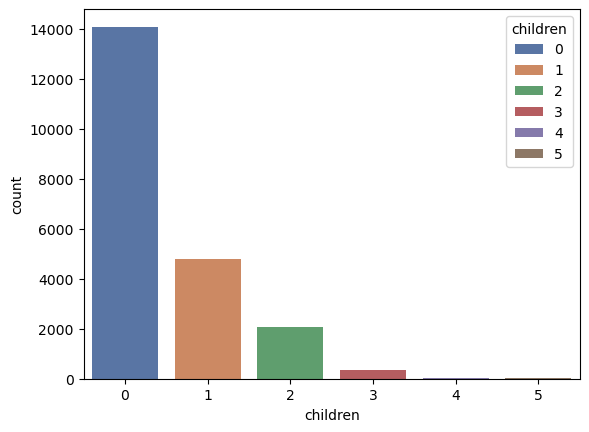

In [35]:
sb.barplot(data=data_by_children, x=data_by_children.index, y='count', hue=data_by_children.index, palette='deep')

<Axes: xlabel='children', ylabel='%'>

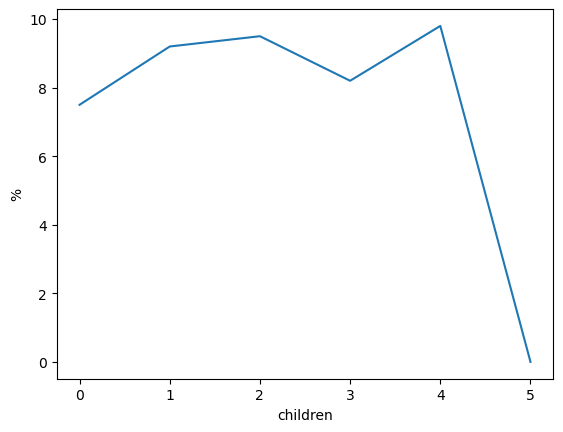

In [36]:
sb.lineplot(data=data_by_children, x='children', y='%')

На первый взгляд зависимость есть (рост более 1.5%). Спад среди клиентов с 3 детьми может быть объяснён небольшим размером выборки (330 человек).

In [37]:
data_by_children['count_ratio'] = data_by_children['count'] / data_by_children['count'].sum()
data_by_children['sum_ratio'] = data_by_children['sum'] / data_by_children['sum'].sum()
print(data_by_children)

          count   sum     ratio    %  count_ratio  sum_ratio
children                                                    
0         14091  1063  0.075438  7.5     0.660588   0.613741
1          4808   444  0.092346  9.2     0.225400   0.256351
2          2052   194  0.094542  9.5     0.096198   0.112009
3           330    27  0.081818  8.2     0.015470   0.015589
4            41     4  0.097561  9.8     0.001922   0.002309
5             9     0  0.000000  0.0     0.000422   0.000000


Похоже, что кредитополучатели без детей возвращают долги чаще, чем клиенты у которых есть дети. Видимо, это оказывает существенное влияние на финансовые возможности потенциального клиента.  
Впрочем, по некоторым группам заёмщиков данных у нас недостаточно.

### Корреляция между семейным положением и фактом задолженности

Проводим аналогичные действия

In [38]:
print(data['family_status'].unique())

['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']


In [39]:
data_by_status = data.groupby('family_status').agg({'debt': ['count', 'sum']})

data_by_status.columns = data_by_status.columns.droplevel()
print(data_by_status)

                       count  sum
family_status                    
Не женат / не замужем   2796  273
в разводе               1189   84
вдовец / вдова           951   63
гражданский брак        4134  385
женат / замужем        12261  927


In [40]:
data_by_status['ratio'] = data_by_status['sum'] / data_by_status['count']
data_by_status['%'] = round(data_by_status['ratio'] * 100, 1)
print(data_by_status.sort_values(by='%', ascending=False))

                       count  sum     ratio    %
family_status                                   
Не женат / не замужем   2796  273  0.097639  9.8
гражданский брак        4134  385  0.093130  9.3
женат / замужем        12261  927  0.075606  7.6
в разводе               1189   84  0.070648  7.1
вдовец / вдова           951   63  0.066246  6.6


Разница в числах значительная, хотя я не могу найти логическую грань между "женат / замужем" и "гражданским браком" (в то время как на числах она есть), так что на мой взгляд зависимости тут может и не быть.

Ещё более контрастная разница для неженатых/незамужних клиентов и разведённых: первые отдают деньги по кредитам на 2.7% случаев реже вторых, хотя различие между этими группами не очевидно.

In [41]:
print(data.loc[data['family_status'] == 'Не женат / не замужем']['dob_years'].mean())
print(data.loc[data['family_status'] == 'в разводе']['dob_years'].mean())

38.36802575107296
45.561816652649284


Разница в среднем возрасте небольшая.

In [42]:
print(len(data.loc[(data['children'] == 0) & (data['family_status'] == 'женат / замужем')])\
          / len(data))

0.35010079227415497


Отметим, что больше трети клиентов состоят в браке без детей

### Зависимость между уровнем дохода и фактом задолженности

Искать зависимость будем по категориям доходности.

In [43]:
print(data.columns)

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'total_income_category', 'purpose_category'],
      dtype='object')


In [44]:
data_by_income = data.groupby('total_income_category').agg({'debt': ['count', 'sum']})

data_by_income.columns = data_by_income.columns.droplevel()
print(data_by_income)

                       count   sum
total_income_category             
A                         25     2
B                       5014   354
C                      15921  1353
D                        349    21
E                         22     2


In [45]:
data_by_income['ratio'] = data_by_income['sum'] / data_by_income['count']
data_by_income['%'] = round(data_by_income['ratio'] * 100, 1)
print(data_by_income.sort_values(by='%', ascending=False))

                       count   sum     ratio    %
total_income_category                            
E                         22     2  0.090909  9.1
C                      15921  1353  0.084982  8.5
A                         25     2  0.080000  8.0
B                       5014   354  0.070602  7.1
D                        349    21  0.060172  6.0


<Axes: xlabel='total_income_category', ylabel='%'>

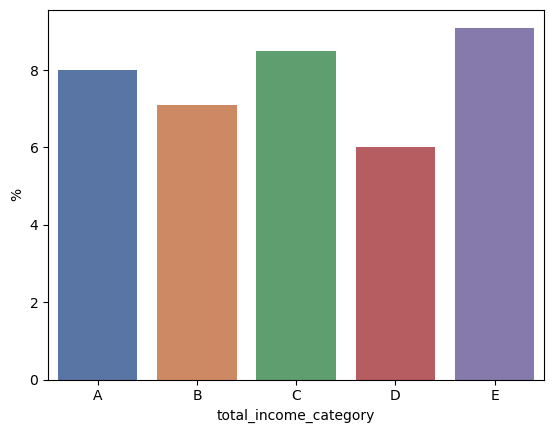

In [46]:
sb.barplot(data=data_by_income, x=data_by_income.index, y='%', hue=data_by_income.index, palette='deep')

Для крайних категорий недостаточно данных для выводов, однако разница между категориями от 50 001 до 200 000 (8.5%) и от 200 001 до 1 000 000 (7.1%) вполне достоверна.  

### Зависимость между целью взятия кредита и фактом его возврата

In [47]:
data_by_purpose = data.groupby('purpose_category').agg({'debt': ['count', 'sum']})

data_by_purpose.columns = data_by_purpose.columns.droplevel()
print(data_by_purpose)

                          count  sum
purpose_category                    
операции с автомобилем     4279  400
операции с недвижимостью  10751  780
получение образования      3988  369
проведение свадьбы         2313  183


In [48]:
data_by_purpose['ratio'] = data_by_purpose['sum'] / data_by_purpose['count']
data_by_purpose['%'] = round(data_by_purpose['ratio'] * 100, 1)
print(data_by_purpose.sort_values(by='%', ascending=False))

                          count  sum     ratio    %
purpose_category                                   
операции с автомобилем     4279  400  0.093480  9.3
получение образования      3988  369  0.092528  9.3
проведение свадьбы         2313  183  0.079118  7.9
операции с недвижимостью  10751  780  0.072551  7.3


<Axes: xlabel='%', ylabel='purpose_category'>

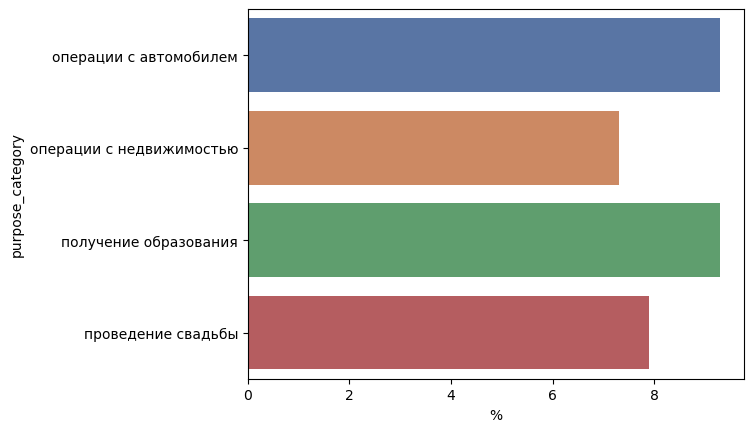

In [49]:
sb.barplot(data=data_by_purpose, y=data_by_purpose.index, x='%', orient='h', hue=data_by_purpose.index, palette='deep')

Здесь данных хватает для выводов по всем категориям. Так кредиты по операциям с недвижимостью или на проведение свадьбы возвращают чаще, чем кредиты на получение образования или покупку автомобиля.

### Возможные причины появления пропусков в данных

Как было показано [ранее](#match), пропуски в доходах и пропуски в трудовом стаже полностью совпадают, из чего можно сделать вывод, что они неслучайны.

In [50]:
print(gaps['income_type'].value_counts())

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64


Как видно, ни один из этих людей не назвал себя безработным.

In [51]:
data_with_gaps = gaps.groupby('income_type').agg({'debt': ['count', 'sum']})

data_with_gaps.columns = data_with_gaps.columns.droplevel()
print(data_with_gaps)

                 count  sum
income_type                
госслужащий        147    7
компаньон          508   30
пенсионер          413   35
предприниматель      1    0
сотрудник         1105   98


In [52]:
data_with_gaps['ratio'] = data_with_gaps['sum'] / data_with_gaps['count']
data_with_gaps['%'] = round(data_with_gaps['ratio'] * 100, 1)
print(data_with_gaps.sort_values(by='%', ascending=False))

                 count  sum     ratio    %
income_type                               
сотрудник         1105   98  0.088688  8.9
пенсионер          413   35  0.084746  8.5
компаньон          508   30  0.059055  5.9
госслужащий        147    7  0.047619  4.8
предприниматель      1    0  0.000000  0.0


Показатели невозврата кредитов не превышают среднестатистических, так что вряд ли доход не указан с каким-то злым умыслом.

Думаю, эти клиенты просто не захотели указывать своё место работы (если такая опция разрешена банком).

По сообажению случайности этих людей пропуски и заполняются медианным значением внутри каждой группы доходов. Среднее арифметическое в данном случае хуже работает, потому что даже внутри группы могут быть выбросы, а медиана робастнее среднего.

## Выводы

1. Разница между бездетными клиентами и теми, у кого 1 или 2 ребёнка действительно есть: 7.5% невозврата против 9.2% и 9.5% соответственно. Для выводов по клиентам с 3, 4 и 5 детьми данных не хватает.
2. В том, что касается семейного положения, можно отметить низкий процент задолженностей для вдов/вдовцов и разведённых (6.6% и 7.1%). В остальном логическая связь плохо ищется.
3. Люди с доходами от 50 001 до 200 000 возвращают кредиты реже (8.5%), чем люди с доходами от 200 001 до 1 000 000. Впрочем природа этих **дробных** чисел мне непонятна. Тем более для студентов и пенсионеров. Я бы уточнил, как числа доходов и трудового стажа были получены и рассчитаны.
4. Довольно чёткая картина получается по целям взятия кредита. Кредиты на автомобиль и образование возвращают реже кредитов на свадьбу или недвижимость(9.3% и 9.3% против 7.9% и 7.3%).